# 时间转换公式，转换为%Y-%m-%d %H:%M:%S

In [12]:
import time
import pandas as pd
import numpy as np

def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt

# 要选用的特征和目标

In [13]:
numeric_feats = ['item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_age_level',
                 'user_star_level', 'shop_review_num_level',
                 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',
                 'hour', 'day',
#                  'user_query_day', 'user_query_day_hour',
#                  'item_brand_query_day', 'item_brand_query_day_hour',
#                  'shop_query_day', 'shop_query_day_hour',
#                  'item_query_day', 'item_query_day_hour'
                 ]

# nominal_feats = ['item_id', 'user_id', 'shop_id', 'item_brand_id', 'item_city_id', 'user_gender_id', 'user_occupation_id', 'context_page_id',
#                  'category_0', 'category_1',
#                  'category_2', 'property_0', 'property_1', 'property_2',
#                  'predict_category_0', 'predict_category_1', 'predict_category_2']

nominal_feats = ['item_id', 'user_id', 'shop_id', 'item_brand_id', 'item_city_id', 'user_gender_id', 'user_occupation_id', 'context_page_id']


# nominal_feats = ['user_gender_id', 'user_occupation_id', 'context_page_id']

features = numeric_feats + nominal_feats

target = 'is_trade'

# 数据转换函数
添加分号的属性列表
根据最近邻填充空值

In [14]:
def extract_date(data):
    data['time'] = data.context_timestamp.apply(timestamp_datetime)
    data['day'] = data.time.apply(lambda x: int(x[8:10]))
    data['hour'] = data.time.apply(lambda x: int(x[11:13]))
    del data['time']
    return data


def extract_manual_features(data, sample_weight=1.0):
    user_query_day = data.groupby(['user_id', 'day']).size(
    ).reset_index().rename(columns={0: 'user_query_day'})
    data = pd.merge(data, user_query_day, how='left',
                    on=['user_id', 'day'])

    user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size(
    ).reset_index().rename(columns={0: 'user_query_day_hour'})
    data = pd.merge(data, user_query_day_hour, how='left',
                    on=['user_id', 'day', 'hour'])

    item_brand_query_day = data.groupby(['item_brand_id', 'day']).size(
    ).reset_index().rename(columns={0: 'item_brand_query_day'})
    data = pd.merge(data, item_brand_query_day, how='left',
                    on=['item_brand_id', 'day'])

    item_brand_query_day_hour = data.groupby(['item_brand_id', 'day', 'hour']).size(
    ).reset_index().rename(columns={0: 'item_brand_query_day_hour'})
    data = pd.merge(data, item_brand_query_day_hour, how='left',
                    on=['item_brand_id', 'day', 'hour'])

    item_query_day = data.groupby(['item_id', 'day']).size(
    ).reset_index().rename(columns={0: 'item_query_day'})
    data = pd.merge(data, item_query_day, how='left', on=['item_id', 'day'])

    item_query_day_hour = data.groupby(['item_id', 'day', 'hour']).size(
    ).reset_index().rename(columns={0: 'item_query_day_hour'})
    data = pd.merge(data, item_query_day_hour, how='left',
                    on=['item_id', 'day', 'hour'])

    shop_query_day = data.groupby(['shop_id', 'day']).size(
    ).reset_index().rename(columns={0: 'shop_query_day'})
    data = pd.merge(data, shop_query_day, how='left', on=['shop_id', 'day'])

    shop_query_day_hour = data.groupby(['shop_id', 'day', 'hour']).size(
    ).reset_index().rename(columns={0: 'shop_query_day_hour'})
    data = pd.merge(data, shop_query_day_hour, how='left',
                    on=['shop_id', 'day', 'hour'])

    feats = [
        'user_query_day', 'user_query_day_hour',
        'item_brand_query_day', 'item_brand_query_day_hour',
        'shop_query_day', 'shop_query_day_hour',
        'item_query_day', 'item_query_day_hour']

    data[feats] = data[feats] / sample_weight


#     print('item_category_list_ing')
#     for i in range(3):
#         data['category_%d'%(i)] = data['item_category_list'].apply(
#             lambda x:x.split(";")[i] if len(x.split(";")) > i else " "
#         )
#     del data['item_category_list']

#     print('item_property_list_ing')
#     for i in range(3):
#         data['property_%d'%(i)] = data['item_property_list'].apply(
#             lambda x:x.split(";")[i] if len(x.split(";")) > i else " "
#         )
#     del data['item_property_list']

#     print('predict_category_property_ing_0')
#     for i in range(3):
#         data['predict_category_%d'%(i)] = data['predict_category_property'].apply(
#             lambda x:str(x.split(";")[i]).split(":")[0] if len(x.split(";")) > i else " "
#         )

#     del data['predict_category_property']

#     context_page_id可以考虑设置为标称属性

#     data = data.replace(to_replace=[-1], value=np.NaN)
#     data[numeric_feats] = data[numeric_feats].fillna(data.mean())
#     data[numeric_feats] = data[numeric_feats].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    return data

## 利用相似性处理空值

# 读取训练样本并转换

In [18]:
df_train = pd.read_csv("round1_ijcai_18_train_20180301.txt", sep=' ')
df_test = pd.read_csv("round1_ijcai_18_test_a_20180301.txt", sep=' ')

df_train.drop_duplicates(inplace=True)
df_train = extract_date(df_train)
df_test = extract_date(df_test)

# 根据日期，取24号为验证集
train_data = df_train.loc[df_train.day < df_train['day'].max()]
val_data = df_train.loc[df_train.day == df_train['day'].max()]

# 测试集保持与25号相同的采样比例
sample_weight = df_test.shape[0] / val_data.shape[0]
# val_data = val_data.sample(frac=sample_weight)

# 提取人工特征
# train_data = extract_manual_features(train_data)
# val_data = extract_manual_features(val_data, sample_weight)

train_data.shape, val_data.shape

((420693, 29), (57418, 29))

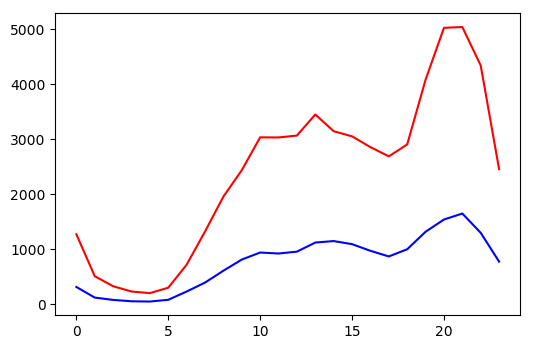

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import matplotlib.pyplot as plt
plt.plot(df_test.groupby(['hour']).size(), color='b', label='25')
plt.plot(val_data.groupby(['hour']).size(), color='r', label='25')
plt.show()

# 使用下面两种方法进行测试

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2", solver='liblinear',
                        max_iter=1000, verbose=1)

from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100, max_features='auto')

clf = gbdt
clf.fit(train_data[features], train_data[target])

loss_train = log_loss(train_data[target], clf.predict_proba(train_data[features]))
predicted = clf.predict_proba(val_data[features])
loss_val = log_loss(val_data[target], predicted)

loss_train, loss_val

# 提交测试数据

In [33]:
df_train = pd.read_csv("../data/round1_ijcai_18_train_20180301.txt", sep=' ')
df_test = pd.read_csv("../data/round1_ijcai_18_test_a_20180301.txt", sep=' ')

df_train.drop_duplicates(inplace=True)
df_train = extract_date(df_train)
df_test = extract_date(df_test)

# 提取人工特征
df_train = extract_manual_features(df_train)
df_test = extract_manual_features(df_test, sample_weight)

gbdt = GradientBoostingClassifier(n_estimators=100, max_features='auto')
gbdt.fit(df_train[features], df_train[target])

df_test['predicted_score'] = gbdt.predict_proba(df_test[features])[:, 1]

df_test[['instance_id', 'predicted_score']].to_csv(
    '20180323.txt', index=False, sep=' ')